<a href="https://colab.research.google.com/github/Sathwik-parimi-07/woc/blob/main/Neural_Networks_binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data=pd.read_csv(r'/content/drive/MyDrive/woc drive/nn_train.csv')

In [ ]:
data.info()
data.head() #all features in numerical values, no categorical data to encode

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Columns: 1027 entries, ID to class_label
dtypes: int64(1027)
memory usage: 626.8 MB


,ID,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_1017,Feature_1018,Feature_1019,Feature_1020,Feature_1021,Feature_1022,Feature_1023,Feature_1024,binary_label,class_label
0,1,81,109,91,96,107,97,103,95,100,...,114,93,91,98,72,92,78,78,0,5
1,2,168,168,169,169,170,171,172,172,175,...,44,44,44,44,44,44,44,44,0,9
2,3,14,20,32,6,27,6,5,34,15,...,63,64,63,60,54,48,43,41,0,5
3,4,60,109,157,126,82,80,70,58,37,...,105,102,99,98,100,105,111,114,1,8
4,5,63,72,86,75,93,77,75,67,62,...,108,109,102,106,96,91,102,89,0,5


In [ ]:
data2=data.drop(['ID'],axis=1) #ID is of no use and first task is only limited to binary  classification
data2.isnull().sum().unique() #all are non null values

array([0])

In [ ]:
x =data2.iloc[:8000,:-2].values    # and first task is only limited to binary  classification
y=data2.iloc[:8000,-2].values

In [ ]:
nan_mask = np.isnan(x)
if np.any(nan_mask):
    print("NaN values found in x at positions:", np.where(nan_mask))

# Check for Inf values
inf_mask = np.isinf(x)
if np.any(inf_mask):
    print("Inf values found in x at positions:", np.where(inf_mask))

In [ ]:
print(f"{x.shape} , {y.shape}")

(8000, 1024) , (8000,)


In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

In [ ]:
def sigmoid_derivative(A):
    return A * (1 - A)

def relu_derivative(z):
    return (z > 0).astype(int)

In [ ]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Stability improvement
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

In [ ]:
# Random parameter initialization
def random_parameters(layers):
    parameters = {}
    for i in range(1, len(layers)):
        parameters[f"w{i}"] = np.random.randn(layers[i], layers[i-1]) * 0.01  # Initialize weights
        parameters[f"b{i}"] = np.zeros((layers[i], 1))  # Initialize biases to zero
    return parameters

In [ ]:
# Forward Propagation
def forward(x, parameters, layers):
    cache = {"A0": x}
    for i in range(1, len(layers)):
        w = parameters[f"w{i}"]
        b = parameters[f"b{i}"]
        A_prev = cache[f"A{i-1}"]
        z = np.dot(w, A_prev) + b  # Linear transformation
        A = relu(z) if i < len(layers) - 1 else sigmoid(z)  # Apply activation function
        cache[f"z{i}"] = z
        cache[f"A{i}"] = A
    return cache


In [ ]:
# Backward Propagation
lambda_val = 0.01
def backward(x, y, parameters, cache, layers):
    grads = {}
    m = x.shape[1]
    A_final = cache[f"A{len(layers)-1}"]

    # Compute dA for the output layer (binary cross-entropy loss derivative)
    dA = -(y / (A_final + 1e-9) - (1 - y) / (1 - A_final + 1e-9))

    for i in reversed(range(1, len(layers))):
        A_prev = cache[f"A{i-1}"]
        z = cache[f"z{i}"]

        # Output layer (sigmoid)
        if i == len(layers) - 1:
            dz = dA * sigmoid_derivative(A_final)
        # Hidden layers (ReLU)
        else:
            dz = dA * relu_derivative(z)

        # Compute gradients for weights and biases
        grads[f"dw{i}"] = np.dot(dz, A_prev.T) / m +(lambda_val / m) * parameters[f"w{i}"]  # Add regularization
        grads[f"db{i}"] = np.sum(dz, axis=1, keepdims=True) / m

        # Backpropagate the error to the previous layer
        dA = np.dot(parameters[f"w{i}"].T, dz)

    return grads

In [ ]:
# Prediction Function
def predict(x, parameters, layers):
    # Perform forward propagation
    cache = forward(x, parameters, layers)

    # The final activation is the predicted probability (sigmoid output for binary classification)
    A_final = cache[f"A{len(layers)-1}"]

    # Convert probabilities to class labels (0 or 1)
    predictions = (A_final > 0.5).astype(int)  # Convert probabilities to binary labels (0 or 1)

    return predictions


In [ ]:
# Example Training Loop
def train_neural_network(X, y, layers, epochs, learning_rate):
    parameters = random_parameters(layers)
    losses = []  # List to store the loss at each epoch

    for epoch in range(epochs):
        # Forward pass
        cache = forward(X, parameters, layers)

        # Backward pass
        grads = backward(X, y, parameters, cache, layers)

        # Update parameters using gradient descent
        for i in range(1, len(layers)):
            parameters[f"w{i}"] -= learning_rate * grads[f"dw{i}"]
            parameters[f"b{i}"] -= learning_rate * grads[f"db{i}"]

        # Calculate loss and store it
        A_final = cache[f"A{len(layers)-1}"]
        loss = -np.mean(y * np.log(A_final + 1e-9) + (1 - y) * np.log(1 - A_final + 1e-9)) \
               + (lambda_val / (2 * X.shape[1])) * np.sum([np.sum(parameters[f"w{i}"]**2) for i in range(1, len(layers))])
        losses.append(loss)

        # Print the loss every 100 epochs
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss:.4f}")

    return parameters, losses

In [ ]:
x.shape

(8000, 1024)

In [ ]:

X = x.T
y = y

layers = [1024, 10, 1]

In [ ]:
# Train the neural network and get the losses at each epoch
parameters, losses = train_neural_network(X, y, layers, epochs=1000, learning_rate=0.001)


Epoch 0, Loss: 0.7205
Epoch 100, Loss: 0.6465
Epoch 200, Loss: 0.6200
Epoch 300, Loss: 0.6166
Epoch 400, Loss: 0.5976
Epoch 500, Loss: 0.5915
Epoch 600, Loss: 0.5817
Epoch 700, Loss: 0.6180
Epoch 800, Loss: 0.5697
Epoch 900, Loss: 0.6656


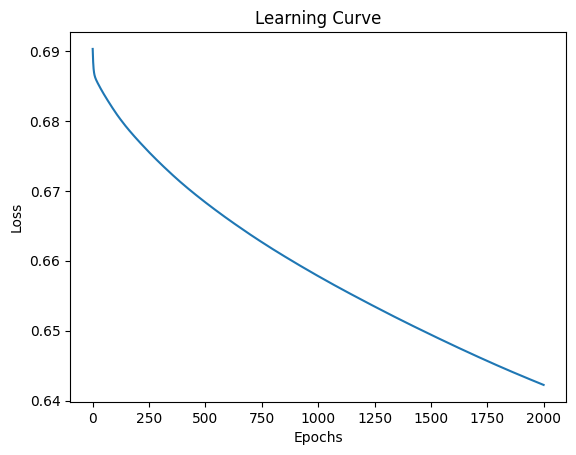

In [ ]:
# Plot the learning curve (loss vs epochs)
plt.plot(losses)
plt.title("Learning Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


In [ ]:
def predict(X, parameters, layers):
    # Perform forward pass
    cache = forward(X, parameters, layers)

    # Get the final output (A_final)
    A_final = cache[f"A{len(layers)-1}"]

    # Apply sigmoid threshold of 0.5 for binary classification
    predictions = (A_final > 0.5).astype(int)

    return predictions


In [ ]:
y_pred = predict(X, parameters, layers)

In [ ]:
def calculate_f1_score(y_true, y_pred):

    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    # True Positives (TP): Predicted 1 and Actual 1
    tp = np.sum((y_pred == 1) & (y_true == 1))

    # False Positives (FP): Predicted 1 and Actual 0
    fp = np.sum((y_pred == 1) & (y_true == 0))

    # False Negatives (FN): Predicted 0 and Actual 1
    fn = np.sum((y_pred == 0) & (y_true == 1))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1_score,precision,recall

In [ ]:
# Calculate F1 score
f1,pre,re = calculate_f1_score(y, y_pred)
print(f"F1 Score: {f1:.2f},precision: {pre:.2f},recall: {re:.2f}")


F1 Score: 0.62,precision: 0.62,recall: 0.62


In [ ]:
f1_score,p,r = calculate_f1_score(y[:10000], y_pred)
print(f"F1 Score: {f1_score},{p},{r}")